In [50]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

In [51]:
DEVICE=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

(1333, 2000, 3)


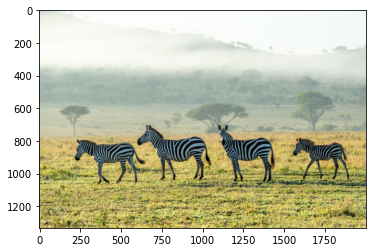

In [52]:
# Data preprocessing
img0=cv2.imread("./drive/MyDrive/Colab Notebooks/faster_rcnn/zebras.jpg")
img0=cv2.cvtColor(img0,cv2.COLOR_BGR2RGB)#컬러 변경하기
print(img0.shape)
plt.imshow(img0)
plt.show()

In [53]:
bbox0=np.array([[223,782,623,1074],[597,695,1038,1050],
                [1088, 699, 1452, 1057], [1544, 771, 1914, 1063]]) #좌표 설정
labels=np.array([1,1,1,1])#zebra면 1, background는 0으로 라벨링

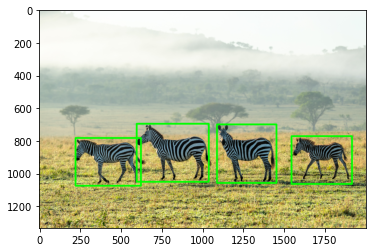

In [54]:
img0_clone=np.copy(img0)
for i in range(len(bbox0)):
  cv2.rectangle(img0_clone,(bbox0[i][0],bbox0[i][1]),
                (bbox0[i][2],bbox0[i][3]),
                color=(0,255,0),thickness=10)
plt.imshow(img0_clone)
plt.show()

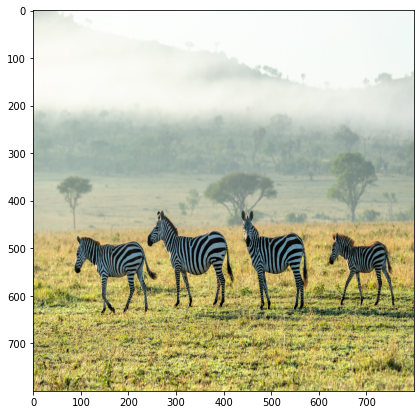

In [55]:
#resize image and bounding boxes
img=cv2.resize(img0,dsize=(800,800),interpolation=cv2.INTER_CUBIC)#사이즈가 변하면 pixel이 늘거나 줄어드니까 그 값을 정하는 방법
plt.figure(figsize=(7,7))
plt.imshow(img)
plt.show()

0.4 0.6001500375093773


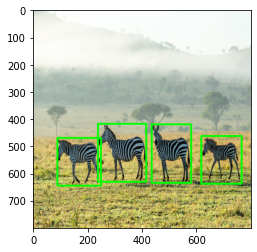

In [56]:
#바운딩 박스도 사이즈 조절
Wratio=800/img0.shape[1]
Hratio=800/img0.shape[0]
print(Wratio,Hratio)

ratioList=[Wratio,Hratio,Wratio,Hratio]
bbox=[]
for box in bbox0:
  box=[int(a*b) for a,b, in zip(box,ratioList)]
  bbox.append(box)
bbox=np.array(bbox)

img_clone=np.copy(img)
for i in range(len(bbox)):
  cv2.rectangle(img_clone,(bbox[i][0],bbox[i][1]),
                (bbox[i][2],bbox[i][3]),color=(0,255,0),thickness=5)
plt.imshow(img_clone)
plt.show()

# Define Featrue extractor

In [57]:
#backbone이 vgg
model=torchvision.models.vgg16(pretrained=True).to(DEVICE)#통과하는 cnn
features=list(model.features)
print(len(features))
print(features)

31
[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [58]:
dummy_img=torch.zeros((1,3,800,800)).float()
print(dummy_img.shape)

req_features=[]
output=dummy_img.clone().to(DEVICE)

for feature in features:
  output=feature(output)#output.size()는 (batch,channel,width,height)로 구성
  if output.size()[2] < 800//16:#만약 output의 가로 길이가 50보다 작다면 
    break
  req_features.append(feature)
  out_channels=output.size()[1]
print(len(req_features))
print(out_channels)
#50인 이유는 featuremap은 50*50크기로 도출시키기 위해서

torch.Size([1, 3, 800, 800])
30
512


In [59]:
#처음 단계인 cnn을 통과하는 것
faster_rcnn_feature_extractor=nn.Sequential(*req_features)

In [60]:
transform=transforms.Compose([transforms.ToTensor()])
imgTensor=transform(img).to(DEVICE)
imgTensor=imgTensor.unsqueeze(0)#배치차원 만들기
output_map=faster_rcnn_feature_extractor(imgTensor)

print(output_map.size())

torch.Size([1, 512, 50, 50])


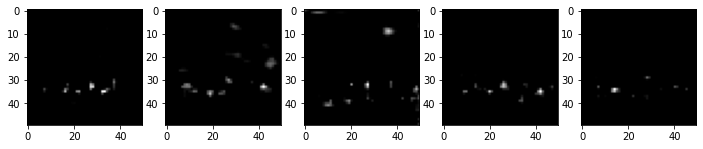

In [61]:
imgArray=output_map.data.cpu().numpy().squeeze(0)
#512개 채널중 5개 채널만 visualization 해보자

fig = plt.figure(figsize=(12, 4))
figNo = 1

for i in range(5):
    fig.add_subplot(1, 5, figNo)
    plt.imshow(imgArray[i], cmap='gray')
    figNo += 1
    
plt.show()
#cnn을 통과한 결과


# Generate Anchors Boxes

In [62]:
#generate anchors
feature_size=800//16
ctr_x=np.arange(16,(feature_size+1)*16,16)
ctr_y=np.arange(16,(feature_size+1)*16,16)
print(len(ctr_x))
print(ctr_x)

50
[ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [63]:
index=0
ctr=np.zeros((2500,2)) #50*50해서 2500개 anchors는 각각 anchor box 9개를 만든다.이게 센터 좌표
for i in range(len(ctr_x)):
  for j in range(len(ctr_y)):
    ctr[index,1]=ctr_x[i]-8
    ctr[index,0]=ctr_y[j]-8
    index+=1
print(ctr.shape)
print(ctr[:10,:])

(2500, 2)
[[  8.   8.]
 [ 24.   8.]
 [ 40.   8.]
 [ 56.   8.]
 [ 72.   8.]
 [ 88.   8.]
 [104.   8.]
 [120.   8.]
 [136.   8.]
 [152.   8.]]


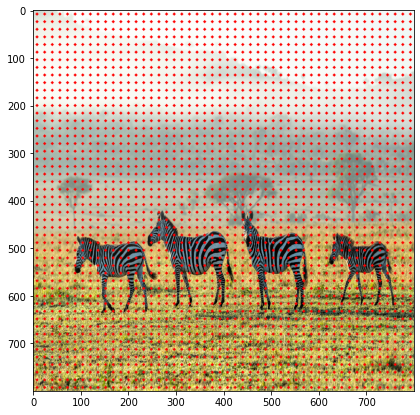

In [64]:
img_clone2=np.copy(img)
ctr_int=ctr.astype('int32')
plt.figure(figsize=(7,7))
for i in range(ctr.shape[0]):
  cv2.circle(img_clone2,(ctr_int[i][0],ctr_int[i][1]),
             radius=1,color=(255,0,0),thickness=3)
plt.imshow(img_clone2)
plt.show()
#앵커 확인

In [65]:
from re import I
#2500개의 anchor마다 9개의 박스를 생성시킨다.
ratios=[0.5,1,2]
scales=[8,16,32]
sub_sample=16

anchor_boxes=np.zeros(((feature_size*feature_size*9),4))
index=0
for c in ctr:
  ctr_y,ctr_x=c
  for i in range(len(ratios)):
    for j in range(len(scales)):
      h=sub_sample*scales[j]*np.sqrt(ratios[i])
      w=sub_sample*scales[j]*np.sqrt(1./ratios[i])

      anchor_boxes[index,1]=ctr_y-h/2#앵커 중심좌표를 기준으로 꼭지점 좌표
      anchor_boxes[index,0]=ctr_x-w/2
      anchor_boxes[index,3]=ctr_y+h/2
      anchor_boxes[index,2]=ctr_x+w/2
      index+=1
print(anchor_boxes.shape)
print(anchor_boxes[:10,:])

(22500, 4)
[[ -82.50966799  -37.254834     98.50966799   53.254834  ]
 [-173.01933598  -82.50966799  189.01933598   98.50966799]
 [-354.03867197 -173.01933598  370.03867197  189.01933598]
 [ -56.          -56.           72.           72.        ]
 [-120.         -120.          136.          136.        ]
 [-248.         -248.          264.          264.        ]
 [ -37.254834    -82.50966799   53.254834     98.50966799]
 [ -82.50966799 -173.01933598   98.50966799  189.01933598]
 [-173.01933598 -354.03867197  189.01933598  370.03867197]
 [ -82.50966799  -21.254834     98.50966799   69.254834  ]]


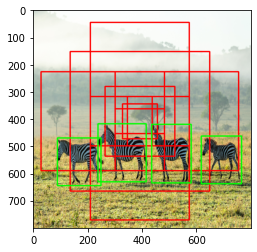

In [66]:
img_clone=np.copy(img)

for i in range(11025,11034):
  x1=int(anchor_boxes[i][0])
  y1=int(anchor_boxes[i][1])
  x2=int(anchor_boxes[i][2])
  y2=int(anchor_boxes[i][3])
  cv2.rectangle(img_clone,(x1,y1),(x2,y2),color=(255,0,0),thickness=3)

for i in range(len(bbox)):
  cv2.rectangle(img_clone,(bbox[i][0],bbox[i][1]),
                (bbox[i][2],bbox[i][3]),color=(0,255,0),thickness=3)
plt.imshow(img_clone)
plt.show()


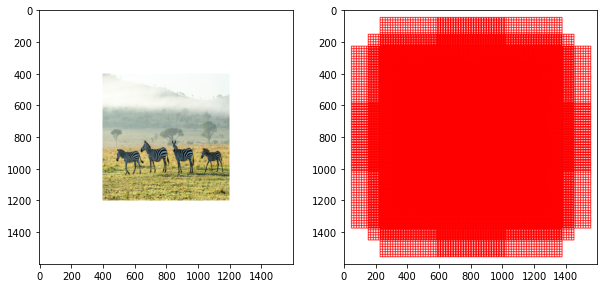

In [67]:
# draw all anchor boxes

# add paddings(can't draw anchor boxes out of image boundary)
img_clone3 = np.copy(img)
img_clone4 = cv2.copyMakeBorder(img_clone3,400,400,400,400,cv2.BORDER_CONSTANT, value=(255, 255, 255))
img_clone5 = np.copy(img_clone4)

for i in range(len(anchor_boxes)):
    x1 = int(anchor_boxes[i][0])
    y1 = int(anchor_boxes[i][1])
    x2 = int(anchor_boxes[i][2])
    y2 = int(anchor_boxes[i][3])
    
    cv2.rectangle(img_clone5, (x1+400, y1+400), (x2+400, y2+400), color=(255, 0, 0),
                 thickness=3)

plt.figure(figsize=(10, 10))
plt.subplot(121), plt.imshow(img_clone4)
plt.subplot(122), plt.imshow(img_clone5)
plt.show()

# Target Anchors

In [68]:
#이미지 안에 있는 박스만 고르기, 적잘한 anchor bax 선택
#index를 반환하는 np.where
index_inside=np.where((anchor_boxes[:,0]>=0)&
                      (anchor_boxes[:,1]>=0)&
                      (anchor_boxes[:,2]<=800)&
                      (anchor_boxes[:,3]<=800))[0]
print(index_inside)

valid_anchor_boxes=anchor_boxes[index_inside]
print(valid_anchor_boxes.shape)

[ 1410  1419  1428 ... 21075 21084 21093]
(8940, 4)


In [69]:
#calculate IoUs
ious=np.empty((len(valid_anchor_boxes),4),dtype=np.float32)
ious.fill(0)

for i,anchor_box in enumerate(valid_anchor_boxes):
  xa1,ya1,xa2,ya2=anchor_box
  anchor_area=(xa2-xa1)*(ya2-ya1)

  for j,gt_box in enumerate(bbox):
    xb1, yb1, xb2, yb2 = gt_box
    box_area = (xb2 - xb1) * (yb2 - yb1)
        
    inter_x1 = max([xb1, xa1])
    inter_y1 = max([yb1, ya1])
    inter_x2 = min([xb2, xa2])
    inter_y2 = min([yb2, ya2])

    if(inter_x1<inter_x2) and(inter_y1<inter_y2):
      inter_area=(inter_x2-inter_x1)*(inter_y2-inter_y1)
      iou=inter_area/(anchor_area+box_area-inter_area)
    else:
      iou=0

    ious[i,j]=iou

print(ious.shape)
print(ious[8930:8940, :])

(8940, 4)
[[0.         0.         0.         0.37780452]
 [0.         0.         0.         0.33321926]
 [0.         0.         0.         0.29009855]
 [0.         0.         0.         0.24967977]
 [0.         0.         0.         0.2117167 ]
 [0.         0.         0.         0.17599213]
 [0.         0.         0.         0.14231375]
 [0.         0.         0.         0.11051063]
 [0.         0.         0.         0.08043041]
 [0.         0.         0.         0.05193678]]


In [70]:
#sample positive/negative anchor boxes

gt_argmax_ious=ious.argmax(axis=0)
print(gt_argmax_ious)

gt_max_ious=ious[gt_argmax_ious,np.arange(ious.shape[1])]
print(gt_max_ious)

gt_argmax_ious=np.where(ious==gt_max_ious)[0]
print(gt_argmax_ious)

[1008 2862 5935 8699]
[0.58514285 0.5752716  0.5255493  0.6325869 ]
[1008 1013 1018 1226 1232 1238 2862 2869 2876 3108 3115 3122 3336 3343
 3350 3354 3357 3361 3364 3368 3371 3377 3383 3389 3600 3607 3614 3846
 3853 3860 5935 5942 6164 6171 6178 6181 6185 6188 6192 6198 6427 6434
 8699 8703 8707]


In [71]:
argmax_ious=ious.argmax(axis=1)
print(argmax_ious)

max_ious=ious[np.arange(len(index_inside)),argmax_ious]
print(max_ious.shape)

[0 0 0 ... 3 3 3]
(8940,)


In [72]:
label=np.empty((len(index_inside),),dtype=np.int32)
label.fill(-1)
print(label.shape)

(8940,)


In [73]:
# use IoU to assign 1 (objects) to two kind of anchors
# a) the anchors with the highest IoU overlap with a ground truth box
# b) an anchor that has an IoU overlap higher than 0.7 with ground truth box

# Assign 0 (background) to an anchor if its IoU ratio is lower than 0.3

pos_iou_threshold = 0.7
neg_iou_threshold = 0.3

label[gt_argmax_ious] = 1
label[max_ious >= pos_iou_threshold] = 1
label[max_ious < neg_iou_threshold] = 0

In [74]:
n_sample=256
pos_ratio=0.5
n_pos=pos_ratio*n_sample
pos_index=np.where(label==1)[0]
if(len(pos_index)>n_pos):
  disable_index=np.random.choice(pos_index,size=(len(pos_index)-n_pos),replace=False)
  label[disable_index]=-1

n_neg=n_sample*np.sum(label==1)
neg_index=np.where(label==0)[0]

if len(neg_index)>n_neg:
  disable_index=np.randon.choice(neg_index,size=(len(neg_index)-n_neg),replace=False)
  label[disable_index]=-1

In [75]:
#iou가 가장 높았던 bbox의 좌표를 list화
max_iou_bbox = bbox[argmax_ious]
print(max_iou_bbox.shape)

height = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
width = valid_anchor_boxes[:, 2] - valid_anchor_boxes[:, 0]
ctr_y = valid_anchor_boxes[:, 1] + 0.5 * height
ctr_x = valid_anchor_boxes[:, 0] + 0.5 * width

base_height = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_width = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_ctr_y = max_iou_bbox[:, 1] + 0.5 * base_height
base_ctr_x = max_iou_bbox[:, 0] + 0.5 * base_width

eps = np.finfo(height.dtype).eps#표현가능한 가장 작은 값
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)

anchor_locs = np.vstack((dx, dy, dw, dh)).transpose()
print(anchor_locs)

(8940, 4)
[[ 1.24848541  2.49973296  0.56971714 -0.03381788]
 [ 1.24848541  2.41134461  0.56971714 -0.03381788]
 [ 1.24848541  2.32295626  0.56971714 -0.03381788]
 ...
 [-0.5855728  -0.63252911  0.4917556  -0.03381788]
 [-0.5855728  -0.72091746  0.4917556  -0.03381788]
 [-0.5855728  -0.80930581  0.4917556  -0.03381788]]


In [76]:
anchor_labels=np.empty((len(anchor_boxes),),dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside]=label

anchor_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill(0)
anchor_locations[index_inside, :] = anchor_locs
print(anchor_locations.shape)
print(anchor_locations[:10, :])

(22500, 4)
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


# RPN

In [77]:
#RPN으로 input image 보내기
in_channels=512
mid_channels=512
n_anchor=9

conv1=nn.Conv2d(in_channels,mid_channels,3,1,1).to(DEVICE)
conv1.weight.data.normal_(0,0.01)
conv1.bias.data.zero_()

#bounding box regressor

reg_layer=nn.Conv2d(mid_channels,n_anchor*4,1,1,0).to(DEVICE)
reg_layer.weight.data.normal_(0,0.01)#가중치 초기화 시 표준화
reg_layer.bias.data.zero_()

#classifier
cls_layer=nn.Conv2d(mid_channels,n_anchor*2,1,1,0).to(DEVICE)
cls_layer.weight.data.normal_(0,0.01)
cls_layer.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [78]:
x=conv1(output_map.to(DEVICE))
pred_anchor_locs=reg_layer(x)
pred_cls_scores=cls_layer(x)
print(pred_anchor_locs.shape,pred_cls_scores.shape)

torch.Size([1, 36, 50, 50]) torch.Size([1, 18, 50, 50])


In [79]:
pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print(pred_anchor_locs.shape)
pred_cls_scores=pred_cls_scores.permute(0,2,3,1).contiguous()
print(pred_cls_scores.shape)
objectness_score=pred_cls_scores.view(1,50,50,9,2)[:,:,:,:,1].contiguous().view(1,-1)
print(objectness_score.shape)

pred_cls_scores=pred_cls_scores.view(1,-1,2)
print(pred_cls_scores.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 50, 50, 18])
torch.Size([1, 22500])
torch.Size([1, 22500, 2])


In [80]:
rpn_loc=pred_anchor_locs[0]
rpn_score=pred_cls_scores[0]
gt_rpn_loc=torch.from_numpy(anchor_locations)
gt_rpn_score=torch.from_numpy(anchor_labels)
print(rpn_loc.shape,rpn_score.shape,gt_rpn_loc.shape,gt_rpn_score.shape)

torch.Size([22500, 4]) torch.Size([22500, 2]) torch.Size([22500, 4]) torch.Size([22500])


In [81]:
#multitask loss
rpn_cls_loss=F.cross_entropy(rpn_score,gt_rpn_score.long().to(DEVICE),ignore_index=-1)
print(rpn_cls_loss)

tensor(0.6966, grad_fn=<NllLossBackward0>)


In [82]:
pos=gt_rpn_score>0
mask=pos.unsqueeze(1).expand_as(rpn_loc)
print(mask.shape)
#positive label의 바운딩 박스만
mask_loc_preds=rpn_loc[mask].view(-1,4)
mask_loc_targets=gt_rpn_loc[mask].view(-1,4)
print(mask_loc_preds.shape,mask_loc_targets.shape)

x=torch.abs(mask_loc_targets.cpu()-mask_loc_preds.cpu())
rpn_loc_loss=((x<1).float()*0.5*x**2)+((x>=1).float()*(x-0.5))
print(rpn_loc_loss.sum())

torch.Size([22500, 4])
torch.Size([45, 4]) torch.Size([45, 4])
tensor(6.4592, dtype=torch.float64, grad_fn=<SumBackward0>)


In [83]:
#combining both the rpn_cls_loss and rpn_reg_loss

rpn_lambda=10
N_reg=(gt_rpn_score<0).float().sum()
rpn_loc_loss=rpn_loc_loss.sum()/N_reg
rpn_loss=rpn_cls_loss+(rpn_lambda*rpn_loc_loss)
print(rpn_loss)

tensor(0.7009, dtype=torch.float64, grad_fn=<AddBackward0>)


# Proposal layer

In [84]:
#transform anchor boxes
#RPN으로 예측된 22500 ROI들을 Fast RCNN으로 보내고, 22500 에서 2000개로 감소시킨다.
nms_thresh=0.7
n_train_pre_nms=12000
n_train_post_nms=2000
n_test_pre_nms=6000
n_test_post_nms=300
min_size=16

In [85]:
# format converted from [x1, y1, x2, y2] to [ctrx, ctry, w, h]
anc_height=anchor_boxes[:,3]-anchor_boxes[:,1]
anc_width=anchor_boxes[:,2]-anchor_boxes[:,0]
anc_ctr_y=anchor_boxes[:,1]+0.5*anc_height
anc_ctr_x=anchor_boxes[:,0]+0.5*anc_width
print(anc_ctr_x.shape)

(22500,)


In [86]:
# The 22500 anchor boxes location and labels predicted by RPN (convert to numpy)
# format = (dx, dy, dw, dh)

pred_anchor_locs_numpy = pred_anchor_locs[0].cpu().data.numpy()
objectness_score_numpy = objectness_score[0].cpu().data.numpy()

dy = pred_anchor_locs_numpy[:, 1::4]
dx = pred_anchor_locs_numpy[:, 0::4]
dh = pred_anchor_locs_numpy[:, 3::4]
dw = pred_anchor_locs_numpy[:, 2::4]
print(dy.shape)

(22500, 1)


In [87]:
# ctr_y = dy predicted by RPN * anchor_h + anchor_cy
# ctr_x similar
# h = exp(dh predicted by RPN) * anchor_h
# w similar
ctr_y=dy*anc_height[:,np.newaxis]+anc_ctr_y[:,np.newaxis]
ctr_x=dx*anc_width[:,np.newaxis]+anc_ctr_x[:,np.newaxis]
h=np.exp(dh)*anc_height[:,np.newaxis]
w=np.exp(dw)*anc_width[:,np.newaxis]
print(w.shape)

(22500, 1)


In [88]:
roi = np.zeros(pred_anchor_locs_numpy.shape, dtype=anchor_locs.dtype)
roi[:, 0::4] = ctr_x - 0.5 * w
roi[:, 1::4] = ctr_y - 0.5 * h
roi[:, 2::4] = ctr_x + 0.5 * w
roi[:, 3::4] = ctr_y + 0.5 * h

print(roi.shape)

(22500, 4)


In [89]:
img_size=(800,800)
roi[:,slice(0,4,2)]=np.clip(roi[:,slice(0,4,2)],0,img_size[0])
roi[:,slice(1,4,2)]=np.clip(roi[:,slice(1,4,2)],0,img_size[1])

print(roi.shape,np.max(roi),np.min(roi))

(22500, 4) 800.0 0.0


In [90]:
hs=roi[:,3]-roi[:,1]
ws=roi[:,2]-roi[:,0]
keep=np.where((hs>=min_size)&(ws>=min_size))[0]
roi=roi[keep,:]
score=objectness_score_numpy[keep]
print(keep.shape,roi.shape,score.shape)

(22500,) (22500, 4) (22500,)


In [91]:
order=score.ravel().argsort()[::-1]
print(order.shape)

(22500,)


In [92]:
order=order[:n_train_pre_nms]
roi=roi[order,:]
print(order.shape,roi.shape)

(12000,) (12000, 4)


In [93]:
x1=roi[:,0]
y1=roi[:,1]
x2=roi[:,2]
y2=roi[:,3]

areas=(x2-x1+1)*(y2-y1+1)

In [94]:
# take the indexes of order the probability score in descending order
# non maximum suppression

order = order.argsort()[::-1]
keep = []

while (order.size > 0):
  i = order[0] # take the 1st elt in roder and append to keep
  keep.append(i)

  xx1 = np.maximum(x1[i], x1[order[1:]])
  yy1 = np.maximum(y1[i], y1[order[1:]])
  xx2 = np.minimum(x2[i], x2[order[1:]])
  yy2 = np.minimum(y2[i], y2[order[1:]])

  w = np.maximum(0.0, xx2 - xx1 + 1)
  h = np.maximum(0.0, yy2 - yy1 + 1)

  inter = w * h
  ovr = inter / (areas[i] + areas[order[1:]] - inter)
  inds = np.where(ovr <= nms_thresh)[0]
  order = order[inds + 1]

keep = keep[:n_train_post_nms] # while training/testing, use accordingly
roi = roi[keep]
print(len(keep), roi.shape)

2000 (2000, 4)


# Proposal Target layer

In [95]:
n_sample = 128 # number of samples from roi
pos_ratio = 0.25 # number of positive examples out of the n_samples
pos_iou_thresh = 0.5 # min iou of region proposal with any ground truth object to consider it as positive label
neg_iou_thresh_hi = 0.5 # iou 0~0.5 is considered as negative (0, background)
neg_iou_thresh_lo = 0.0

In [96]:
ious = np.empty((len(roi), bbox.shape[0]), dtype = np.float32)
ious.fill(0)

for num1, i in enumerate(roi):
  ya1, xa1, ya2, xa2 = i
  anchor_area = (ya2 - ya1) * (xa2 - xa1)

  for num2, j in enumerate(bbox):
    yb1, xb1, yb2, xb2 = j
    box_area = (yb2 - yb1) * (xb2 - xb1)
    inter_x1 = max([xb1, xa1])
    inter_y1 = max([yb1, ya1])
    inter_x2 = min([xb2, xa2])
    inter_y2 = min([yb2, ya2])

    if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
      inter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
      iou = inter_area / (anchor_area + box_area - inter_area)
    else:
      iou = 0
    ious[num1, num2] = iou

print(ious.shape)

(2000, 4)


In [97]:

gt_assignment = ious.argmax(axis=1)
max_iou = ious.max(axis=1)

print(gt_assignment)
print(max_iou)

# assign the labels to each proposal
gt_roi_label = labels[gt_assignment]
print(gt_roi_label)

[0 3 0 ... 0 0 0]
[0.         0.20144476 0.         ... 0.4290433  0.42643794 0.2860013 ]
[1 1 1 ... 1 1 1]


In [98]:
# select the foreground rois as pre the pos_iou_thresh
# and n_sample x pos_ratio (128 x 0.25 = 32) foreground samples

pos_roi_per_image = 32
pos_index = np.where(max_iou >= pos_iou_thresh)[0]
pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))

if pos_index.size > 0:
  pos_index = np.random.choice(
      pos_index, size=pos_roi_per_this_image, replace=False)
  
print(pos_roi_per_this_image)
print(pos_index)

25
[ 851  608 1153  848 1207  547 1317 1824  546  170  138  720   18  779
  231  714  204   16  661  137 1768 1263 1200  782 1702]


In [99]:
# similarly we do for negative(background) region proposals

neg_index = np.where((max_iou < neg_iou_thresh_hi) &
                     (max_iou >= neg_iou_thresh_lo))[0]
neg_roi_per_this_image = n_sample - pos_roi_per_this_image
neg_roi_per_this_image = int(min(neg_roi_per_this_image, neg_index.size))

if neg_index.size > 0:
  neg_index = np.random.choice(
    neg_index, size = neg_roi_per_this_image, replace=False)
  
print(neg_roi_per_this_image)
print(neg_index)

103
[1202  453 1912 1158 1672  104 1121  919 1322 1707  508  746 1301  266
 1027  444  957 1332  617 1549  260  130 1441  646 1663  103    5  596
 1928 1730  459 1996    4 1107  963 1917 1686 1991 1020 1790 1941 1418
  593 1503 1588 1569 1483  918 1884   67  217  984  616   56 1989 1651
  906 1285 1313  194 1032 1786 1903 1303 1421 1882 1381  320 1250 1575
 1468 1116 1691 1281 1407  386  238 1154 1550  305 1703 1817  274 1372
 1416 1704 1410 1819  657  901 1417 1739 1150 1737 1496  126  933  391
  981  359  125 1012 1701]


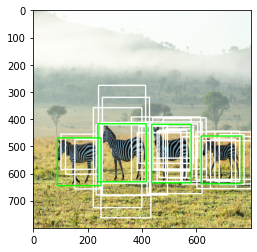

In [100]:
img_clone = np.copy(img)

for i in range(pos_roi_per_this_image):
  x1, y1, x2, y2 = roi[pos_index[i]].astype(int)
  cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255,255,255),
                thickness=3)
  
for i in range(len(bbox)):
  cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), 
                color = (0, 255, 0), thickness=3)

plt.imshow(img_clone)
plt.show()

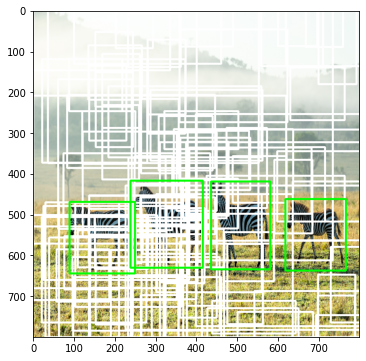

In [101]:
# display RoI samples with negative

img_clone = np.copy(img)

plt.figure(figsize=(9, 6))

for i in range(neg_roi_per_this_image):
  x1, y1, x2, y2 = roi[neg_index[i]].astype(int)
  cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255, 255, 255),
                thickness=3)
  
for i in range(len(bbox)):
  cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), 
                color = (0, 255, 0), thickness=3)
  
plt.imshow(img_clone)
plt.show()

In [102]:
# now we gather positive samples index and negative samples index
# their respective labels and region proposals

keep_index = np.append(pos_index, neg_index)
gt_roi_labels = gt_roi_label[keep_index]
gt_roi_labels[pos_roi_per_this_image:] = 0 # negative labels => 0
sample_roi = roi[keep_index]
print(sample_roi.shape)
(128, 4)
# pick the ground truth objects for these sample_roi and
# later parameterized as we have done while assigning locations to 
# anchor boxes

bbox_for_sampled_roi = bbox[gt_assignment[keep_index]]
print(bbox_for_sampled_roi.shape)
(128, 4)
width = sample_roi[:, 2] - sample_roi[:, 0]
height = sample_roi[:, 3] - sample_roi[:, 1]
ctr_x = sample_roi[:, 0] + 0.5 * width
ctr_y = sample_roi[:, 1] + 0.5 * height

base_width = bbox_for_sampled_roi[:, 2] - bbox_for_sampled_roi[:, 0]
base_height = bbox_for_sampled_roi[:, 3] - bbox_for_sampled_roi[:, 1]
base_ctr_x = bbox_for_sampled_roi[:, 0] + 0.5 * base_width
base_ctr_y = bbox_for_sampled_roi[:, 1] + 0.5 * base_height 
# transform anchor boxes

eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dx = (base_ctr_x - ctr_x) / width
dy = (base_ctr_y - ctr_y) / height
dw = np.log(base_width / width)
dh = np.log(base_height / height)

gt_roi_locs = np.vstack((dx, dy, dw, dh)).transpose()
print(gt_roi_locs.shape)

(128, 4)
(128, 4)
(128, 4)


# ROI Pooling

In [105]:
rois=torch.from_numpy(sample_roi).float()
roi_indices=0*np.ones((len(rois),),dtype=np.int32)
roi_indices=torch.from_numpy(roi_indices).float()
print(rois.shape,roi_indices.shape)

torch.Size([128, 4]) torch.Size([128])


In [106]:
indices_and_rois=torch.cat([roi_indices[:,None],rois],dim=1)
xy_indices_and_rois=indices_and_rois[:,[0,2,1,4,3]]
indices_and_rois=xy_indices_and_rois.contiguous()
print(xy_indices_and_rois.shape)

torch.Size([128, 5])


torch.Size([128, 512, 7, 7])


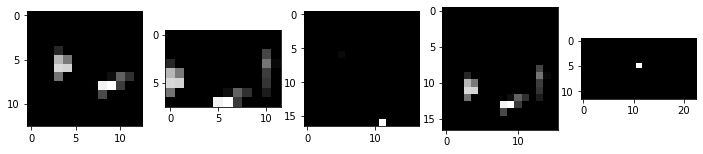

In [107]:
size = (7, 7)
adaptive_max_pool = nn.AdaptiveMaxPool2d(size[0], size[1])
output = []
rois = indices_and_rois.data.float()
rois[:, 1:].mul_(1/16.0) # sub-sampling ratio
rois = rois.long()
num_rois = rois.size(0)

for i in range(num_rois):
  roi = rois[i]
  im_idx = roi[0]
  im = output_map.narrow(0, im_idx, 1)[..., roi[1]:(roi[3]+1), roi[2]:(roi[4]+1)]
  tmp = adaptive_max_pool(im)
  output.append(tmp[0])

output = torch.cat(output, 0)

print(output.size())
torch.Size([128, 512, 7, 7])
# Visualize the first 5 ROI's feature map (for each feature map, only show the 1st channel of d=512)
fig=plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5):
    roi = rois[i]
    im_idx = roi[0]
    im = output_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    tmp = im[0][0].detach().cpu().numpy()
    fig.add_subplot(1, 5, figNo) 
    plt.imshow(tmp, cmap='gray')
    
    figNo +=1
plt.show()

In [113]:
# Reshape the tensor so that we can pass it through the feed forward layer.
k = output.view(output.size(0), -1)
print(k.shape) # 25088 = 7*7*512

torch.Size([128, 25088])


# Fast R-CNN

In [114]:
roi_head_classifier=nn.Sequential(*[nn.Linear(25088,4096),nn.Linear(4096,4096)]).to(DEVICE)
cls_loc=nn.Linear(4096,2*4).to(DEVICE)
cls_loc.weight.data.normal_(0,0.01)
cls_loc.bias.data.zero_()

score=nn.Linear(4096,2).to(DEVICE)

In [115]:
# passing the output of roi pooling to RoI head

k = roi_head_classifier(k.to(DEVICE))
roi_cls_loc = cls_loc(k)
roi_cls_score = score(k)

print(roi_cls_loc.shape, roi_cls_score.shape)

torch.Size([128, 8]) torch.Size([128, 2])


In [116]:
gt_roi_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [117]:
gt_roi_loc = torch.from_numpy(gt_roi_locs)
gt_roi_label = torch.from_numpy(np.float32(gt_roi_labels)).long()
print(gt_roi_loc.shape, gt_roi_label.shape)

#Classification loss
roi_cls_loss = F.cross_entropy(roi_cls_score.cpu(), gt_roi_label.cpu(), ignore_index=-1)

torch.Size([128, 4]) torch.Size([128])


In [118]:
n_sample = roi_cls_loc.shape[0]
roi_loc = roi_cls_loc.view(n_sample, -1, 4)
print(roi_loc.shape)
torch.Size([128, 2, 4])
roi_loc = roi_loc[torch.arange(0, n_sample).long(), gt_roi_label]
print(roi_loc.shape)
torch.Size([128, 4])
# for regression we use smooth l1 loss as defined in the Fast R-CNN paper
pos = gt_roi_label > 0
mask = pos.unsqueeze(1).expand_as(roi_loc)
print(mask.shape)
torch.Size([128, 4])
# take those bounding boxes which have positive labels
mask_loc_preds = roi_loc[mask].view(-1, 4)
mask_loc_targets = gt_roi_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
roi_loc_loss = ((x < 1).float() * 0.5 * x ** 2) + ((x >= 1).float() * (x - 0.5))
print(roi_loc_loss.sum())

torch.Size([128, 2, 4])
torch.Size([128, 4])
torch.Size([128, 4])
torch.Size([25, 4]) torch.Size([25, 4])
tensor(6.6343, dtype=torch.float64, grad_fn=<SumBackward0>)


In [119]:
roi_lambda = 10.
roi_loss = roi_cls_loss + (roi_lambda * roi_loc_loss)
print(roi_loss)

total_loss = rpn_loss + roi_loss
print(total_loss)

tensor([[0.6905, 0.7399, 1.2228, 0.7734],
        [1.6456, 0.7821, 2.3065, 0.7665],
        [2.2834, 0.7956, 2.2511, 1.3505],
        [0.7006, 0.6876, 1.2239, 0.6954],
        [0.6954, 0.6870, 0.7034, 2.2373],
        [0.7760, 0.8258, 1.2597, 0.9260],
        [0.7278, 0.7110, 0.6977, 4.3770],
        [1.3782, 2.2297, 3.1887, 2.4519],
        [1.3614, 0.8312, 1.7414, 0.8222],
        [0.8009, 2.9293, 2.7955, 0.6997],
        [1.0716, 0.7743, 1.1038, 0.7203],
        [0.6976, 2.3915, 0.8202, 2.4523],
        [0.8176, 4.0752, 0.9494, 0.7385],
        [0.6975, 0.9661, 0.6934, 2.9632],
        [1.0549, 2.0178, 2.1176, 0.6942],
        [0.8258, 0.7307, 1.2302, 1.8833],
        [0.8270, 1.4447, 3.4681, 0.6866],
        [0.7092, 0.9109, 0.8558, 0.7569],
        [0.7003, 0.7463, 3.0777, 0.7703],
        [0.9302, 1.0267, 2.6114, 0.7535],
        [2.5491, 1.0978, 1.6805, 1.4412],
        [0.7875, 0.8696, 0.9911, 1.2334],
        [1.0817, 0.8443, 0.6879, 3.1727],
        [1.0545, 0.9437, 0.7080, 2